<a href="https://colab.research.google.com/github/Anthony5234534/STAT3011-Project-II/blob/main/BG_NBD_Actual_predict_plot_of_M1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This file is to visualise an actual - predict plot （RSS) for the BG/NBD - gamma gamma model

In [ ]:
# All package/ library/ moduels

!pip install lifetimes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from decimal import Decimal
import datetime as dt

# BG/ NBD

In [ ]:
# import the orginal data set first
# data set name 'df'

file_name = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/OnlineRetail.xlsx"
df = pd.read_excel(file_name, sheet_name='Online Retail')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print('Date Range: %s to %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))

Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [ ]:
## For using No M1 data frame, run this code to reset the df
# now 'df' will have no M1 data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Step 2: Filter data between '2011-09-30 00:00:00' and '2011-12-31 00:00:00'
start_date = pd.to_datetime('2011-09-30 00:00:00')
end_date = pd.to_datetime('2011-12-31 00:00:00')

df = df[(df['InvoiceDate'] < start_date)]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
369039,569008,22579,WOODEN TREE CHRISTMAS SCANDINAVIAN,24,2011-09-29 18:53:00,0.29,15114.0,United Kingdom
369040,569008,35954,SMALL FOLKART STAR CHRISTMAS DEC,48,2011-09-29 18:53:00,0.19,15114.0,United Kingdom
369041,569009,85099B,JUMBO BAG RED RETROSPOT,50,2011-09-29 19:30:00,2.08,15984.0,United Kingdom
369042,569009,22295,HEART FILIGREE DOVE LARGE,48,2011-09-29 19:30:00,1.65,15984.0,United Kingdom


In [ ]:
df.isna().sum()
df.dropna(inplace=True)


In [ ]:
# Dropping rows with negative quantity.
df = df[~df['Quantity'] < 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265065 entries, 0 to 369043
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    265065 non-null  object        
 1   StockCode    265065 non-null  object        
 2   Description  265065 non-null  object        
 3   Quantity     265065 non-null  int64         
 4   InvoiceDate  265065 non-null  datetime64[ns]
 5   UnitPrice    265065 non-null  float64       
 6   CustomerID   265065 non-null  float64       
 7   Country      265065 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 18.2+ MB


In [ ]:
# Setting data types
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype('str')
df['Description'] = df['Description'].astype('str')
df['StockCode'] = df['StockCode'].astype('str')
df['Country'] = df['Country'].astype('str')
df['UnitPrice'] = df['UnitPrice'].apply(Decimal)

In [ ]:
# Creating the monetary value of the transactions (quantity * price)
df['Monetary'] = df['Quantity'] * df['UnitPrice']
df['Monetary'] = df['Monetary'].apply(Decimal)

In [ ]:
# Computing the summary data (Recency, Frequency, monetary and tenure)
df_rfmt = summary_data_from_transaction_data(transactions = df,
                                         customer_id_col = 'CustomerID',
                                         datetime_col = 'InvoiceDate',
                                         monetary_value_col = 'Monetary')
df_rfmt.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,316.0,0.000
12347.0,5.0,328.0,358.0,674.678
12348.0,3.0,283.0,349.0,301.480
12349.0,0.0,0.0,9.0,0.000
12350.0,0.0,0.0,301.0,0.000


In [ ]:
# size of the data
diff_time = df['InvoiceDate'].max() - df['InvoiceDate'].min()
diff_time

Timedelta('364 days 09:11:00')

In [ ]:
# Getting the ending date of the calibration period.
end_date_cal = df['InvoiceDate'].min() + dt.timedelta(days=200)
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=200))

In [ ]:
df_rfmt_cal = calibration_and_holdout_data(transactions=df,
                                          customer_id_col="CustomerID",
                                          datetime_col = "InvoiceDate",
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
df_rfmt_cal

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,152.0,0.0,164.0
12347.0,3.0,184.0,194.0,2.0,164.0
12348.0,2.0,110.0,185.0,1.0,164.0
12350.0,0.0,0.0,137.0,0.0,164.0
12352.0,3.0,34.0,123.0,3.0,164.0
...,...,...,...,...,...
18273.0,0.0,0.0,84.0,1.0,164.0
18280.0,0.0,0.0,104.0,0.0,164.0
18281.0,0.0,0.0,7.0,0.0,164.0


In [ ]:
l2_coefs = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    # Fitting the model using the calibration dataset.
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'],
        df_rfmt_cal['recency_cal'],
        df_rfmt_cal['T_cal'])
    # Predicting the frequency for the holdout period for all customers.
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'],
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    # Merging the two dataframes and dropping NaN values.
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='CustomerID').dropna()

    # Computing the rmse score
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

# Getting the results
resl = pd.DataFrame(np.array(rmse_list), columns=['rmse_score'])\
             .merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)
resl

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

,rmse_score,L2 coefs
0,2.188782,0.3
1,2.179048,0.4
2,2.173269,0.5
3,2.170412,0.6
4,2.174967,0.7
5,2.175571,0.8
6,2.174495,0.9
7,2.172264,1.0


In [ ]:
# Fitting the model using the calibration dataset.
model = BetaGeoFitter(penalizer_coef=0.80)
model.fit(df_rfmt_cal['frequency_cal'],
        df_rfmt_cal['recency_cal'],
        df_rfmt_cal['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2868 subjects, a: 0.00, alpha: 22.81, b: 0.00, r: 0.29>

In [ ]:
# Predicting the number of purchases in the next 180 days for all customers.
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(70,
                                                                                      df_rfmt['frequency'],
                                                                                      df_rfmt['recency'],
                                                                                      df_rfmt['T'])
df_rfmt.dropna(inplace=True)
# Getting rid of negative values.
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]
df_rfmt

,index,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
0,0,12347.0,5.0,328.0,358.0,674.678000,0.971765,625.881304,766.600528
1,1,12348.0,3.0,283.0,349.0,301.480000,0.618751,334.456416,260.838496
2,2,12352.0,6.0,260.0,287.0,368.256667,1.420410,376.499660,674.053711
3,3,12356.0,2.0,303.0,316.0,269.905000,0.472412,324.957939,193.492634
4,4,12359.0,3.0,274.0,322.0,1941.693333,0.667202,1512.579829,1272.013224
...,...,...,...,...,...,...,...,...,...
2693,2693,18270.0,1.0,228.0,257.0,171.200000,0.319910,304.903481,122.943740
2694,2694,18272.0,4.0,201.0,237.0,517.720000,1.154911,495.174134,720.813127
2695,2695,18273.0,1.0,162.0,248.0,102.000000,0.329705,273.111890,113.496352
2696,2696,18283.0,12.0,328.0,328.0,148.202500,2.451631,172.342867,532.555000


# Gamma Gamma

In [ ]:
# Fitting the GammaGamma model

gg_model = GammaGammaFitter()
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2698 subjects, p: 2.11, q: 3.48, v: 492.48>

In [ ]:
df_rfmt['pred_monetary'] = gg_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])
df_rfmt

,index,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
0,0,12347.0,5.0,328.0,358.0,674.678000,0.971765,625.881304,766.600528
1,1,12348.0,3.0,283.0,349.0,301.480000,0.618751,334.456416,260.838496
2,2,12352.0,6.0,260.0,287.0,368.256667,1.420410,376.499660,674.053711
3,3,12356.0,2.0,303.0,316.0,269.905000,0.472412,324.957939,193.492634
4,4,12359.0,3.0,274.0,322.0,1941.693333,0.667202,1512.579829,1272.013224
...,...,...,...,...,...,...,...,...,...
2693,2693,18270.0,1.0,228.0,257.0,171.200000,0.319910,304.903481,122.943740
2694,2694,18272.0,4.0,201.0,237.0,517.720000,1.154911,495.174134,720.813127
2695,2695,18273.0,1.0,162.0,248.0,102.000000,0.329705,273.111890,113.496352
2696,2696,18283.0,12.0,328.0,328.0,148.202500,2.451631,172.342867,532.555000


# CLV prediction

In [ ]:
# Predicting the CLV.
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 3,# In months
    )
df_rfmt

,level_0,index,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
0,0,0,12347.0,5.0,328.0,358.0,674.678000,0.971765,625.881304,513.605410
1,1,1,12348.0,3.0,283.0,349.0,301.480000,0.618751,334.456416,174.756027
2,2,2,12352.0,6.0,260.0,287.0,368.256667,1.420410,376.499660,451.601089
3,3,3,12356.0,2.0,303.0,316.0,269.905000,0.472412,324.957939,129.635788
4,4,4,12359.0,3.0,274.0,322.0,1941.693333,0.667202,1512.579829,852.220747
...,...,...,...,...,...,...,...,...,...,...
2693,2693,2693,18270.0,1.0,228.0,257.0,171.200000,0.319910,304.903481,82.369589
2694,2694,2694,18272.0,4.0,201.0,237.0,517.720000,1.154911,495.174134,482.928865
2695,2695,2695,18273.0,1.0,162.0,248.0,102.000000,0.329705,273.111890,76.040049
2696,2696,2696,18283.0,12.0,328.0,328.0,148.202500,2.451631,172.342867,356.800079


# Extract M1 data Version II
Method: Used the code form Orgina solution

In [ ]:
# import the orginal data set first
# data set name 'df'

file_name = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/OnlineRetail.xlsx"
df = pd.read_excel(file_name, sheet_name='Online Retail')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Remove quantities that are less than 0 (possibly returned items)
df = df.loc[df['Quantity'] > 0]

In [ ]:
# Remove blank customer IDs
df = df[pd.notnull(df['CustomerID'])]

In [ ]:
# View our data range
print('Date Range: %s to %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))

Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [ ]:
# taking all of the transactions that occurred before December 01, 2011
df = df.loc[df['InvoiceDate'] < '2011-12-01']

In [ ]:
# Create a Sales Revenue Column
df['Sales'] = df['Quantity'] * df['UnitPrice']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
516364,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444.0,United Kingdom,5.00
516365,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444.0,United Kingdom,11.90
516366,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444.0,United Kingdom,12.48
516367,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444.0,United Kingdom,7.95


In [ ]:
# Get a orders summary dataset that shows the total in sales made per customer invoice
orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({'Sales': sum,'InvoiceDate': max})
orders_df.head(10)

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00
           562032       584.91 2011-08-02 08:48:00
           573511      1294.32 2011-10-31 12:25:00
12348.0    539318       892.80 2010-12-16 19:09:00
           541998       227.44 2011-01-25 10:42:00
           548955       367.00 2011-04-05 10:47:00

In [ ]:
# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})

In [ ]:
# Rename our columns by combinng it with the top row
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]

In [ ]:
# Create summary statistics in 3 month intervals for customer Sales

# Use 3M for 3 month
clv_freq = '3M'

# Groupby customer ID now, and group all invoices for 3 month cycles.
# Aggregate on sum, mean and counts
data_df = orders_df.reset_index().groupby(['CustomerID', pd.Grouper(key='InvoiceDate', freq=clv_freq)]).agg({
    'Sales': [sum, groupby_mean, groupby_count],})

data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1
1,12347.0,2010-12-31,711.79,711.790,1
2,12347.0,2011-03-31,475.39,475.390,1
3,12347.0,2011-06-30,1018.77,509.385,2
4,12347.0,2011-09-30,584.91,584.910,1


In [ ]:
# Adding Recency 'M'

# Get the M
date_month_map = {str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True))}

# Create our M Column
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:10]])
data_df.head(10)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1,M_4
1,12347.0,2010-12-31,711.79,711.790,1,M_5
2,12347.0,2011-03-31,475.39,475.390,1,M_4
3,12347.0,2011-06-30,1018.77,509.385,2,M_3
4,12347.0,2011-09-30,584.91,584.910,1,M_2
5,12347.0,2011-12-31,1294.32,1294.320,1,M_1
6,12348.0,2010-12-31,892.80,892.800,1,M_5
7,12348.0,2011-03-31,227.44,227.440,1,M_4
8,12348.0,2011-06-30,367.00,367.000,1,M_3
9,12348.0,2011-09-30,310.00,310.000,1,M_2


In [ ]:
# Added, to calculate the start date and end date

# Assuming you already have the data frame 'data_df' with 'InvoiceDate' column
# First, make sure 'InvoiceDate' is in datetime format
data_df['InvoiceDate'] = pd.to_datetime(data_df['InvoiceDate'])

# Step 1: Find the most recent date (max date) in your dataset
max_date = data_df['InvoiceDate'].max()
print("Most recent date:", max_date)

# Step 2: Calculate the start date of the 3-month period
# Subtract 3 months from the most recent date
start_date_m1 = max_date - pd.DateOffset(months=3)
print("Start date of M1:", start_date_m1)

# Step 3: Define the end date (which is the most recent date itself)
end_date_m1 = max_date
print("End date of M1:", end_date_m1)

Most recent date: 2011-12-31 00:00:00
Start date of M1: 2011-09-30 00:00:00
End date of M1: 2011-12-31 00:00:00


In [ ]:
# Create our Response DF
M1_Actual_df = data_df.loc[data_df['M'] == 'M_1', ['CustomerID', 'sales_sum']]

M1_Actual_df.columns = ['CustomerID', 'CLV_'+clv_freq]
M1_Actual_df.head()

random_state=3011
M1_Actual_sample = M1_Actual_df.sample(frac=0.58)
M1_Actual_sample

,CustomerID,CLV_3M
5433,15806.0,262.70
2758,14093.0,442.85
3944,14836.0,102.45
167,12438.0,2016.78
8854,18045.0,189.40
...,...,...
6715,16671.0,309.39
7488,17159.0,612.21
7673,17287.0,183.81
6069,16221.0,549.49


# Merge data set

In [ ]:
# Predicting the CLV.
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 3,# In months
    )
df_rfmt

,level_0,index,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
0,0,0,12347.0,5.0,328.0,358.0,674.678000,0.971765,625.881304,766.600528
1,1,1,12348.0,3.0,283.0,349.0,301.480000,0.618751,334.456416,260.838496
2,2,2,12352.0,6.0,260.0,287.0,368.256667,1.420410,376.499660,674.053711
3,3,3,12356.0,2.0,303.0,316.0,269.905000,0.472412,324.957939,193.492634
4,4,4,12359.0,3.0,274.0,322.0,1941.693333,0.667202,1512.579829,1272.013224
...,...,...,...,...,...,...,...,...,...,...
2693,2693,2693,18270.0,1.0,228.0,257.0,171.200000,0.319910,304.903481,122.943740
2694,2694,2694,18272.0,4.0,201.0,237.0,517.720000,1.154911,495.174134,720.813127
2695,2695,2695,18273.0,1.0,162.0,248.0,102.000000,0.329705,273.111890,113.496352
2696,2696,2696,18283.0,12.0,328.0,328.0,148.202500,2.451631,172.342867,532.555000


In [ ]:
# df_rfmt = df_rfmt.reset_index()
# df_rfmt

In [ ]:
df_rfmt['CustomerID'] = df_rfmt['CustomerID'].astype(str)
M1_Actual_sample['CustomerID'] = M1_Actual_sample['CustomerID'].astype(str)

# Merge the two dataframes on 'CustomerID', ensuring only customers that exist in both are kept (Inner Join)
combined_df = df_rfmt.merge(M1_Actual_sample, on='CustomerID', how='inner')

# Display the combined dataframe
combined_df
len(combined_df)


1071

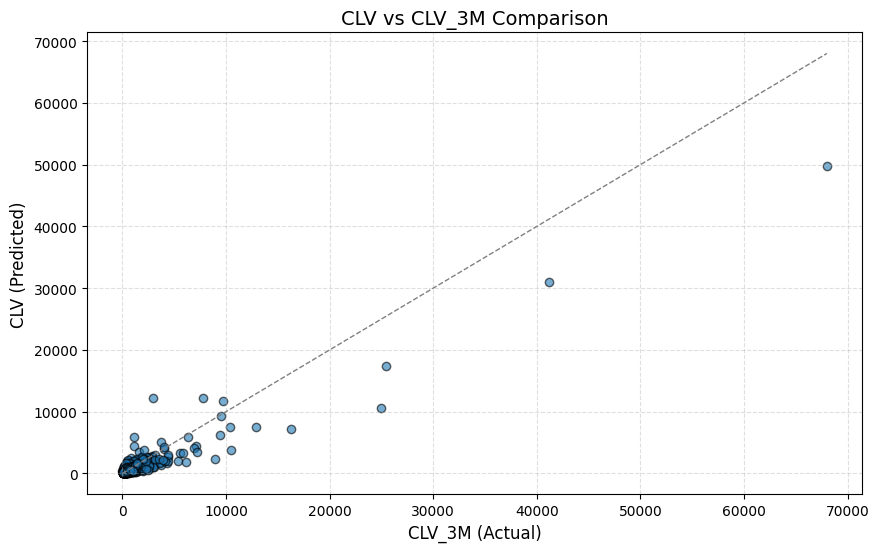

In [ ]:
import matplotlib.pyplot as plt

# Create the scatter plot using plt.scatter
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['CLV_3M'], combined_df['CLV'], alpha=0.6, edgecolor='k')

# Add a 45-degree reference line from (0,0) to max observed value
max_value = max(combined_df['CLV_3M'].max(), combined_df['CLV'].max())
plt.plot([0, max_value], [0, max_value],
         color='gray', lw=1, linestyle='--',
         label='CLV = CLV_3M')

# Customize labels and title
plt.xlabel('CLV_3M (Actual)', fontsize=12)
plt.ylabel('CLV (Predicted)', fontsize=12)
plt.title('CLV vs CLV_3M Comparison', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)

plt.show()

In [ ]:
sum_diff = ((sqrt(combined_df['CLV_3M'] - combined_df['CLV']))^2)).sum()
print(f"Sum of Differences (Actual - Predicted): {sum_diff:.2f}")

SyntaxError: unmatched ')' (<ipython-input-270-8ea6fe714b79>, line 1)

In [ ]:
len(combined_df['CLV_3M'])

1071

In [ ]:
df = pd.DataFrame({
    'Actual': combined_df['CLV_3M'] ,
    'Predicted': combined_df['CLV'],
    'difference': abs(combined_df['CLV_3M'] - combined_df['CLV'])
})

# Display the DataFrame
df

,Actual,Predicted,difference
0,1294.32,766.600528,527.719472
1,311.73,674.053711,362.323711
2,1043.78,615.124246,428.655754
3,739.28,454.534582,284.745418
4,227.20,333.876937,106.676937
...,...,...,...
1066,99.44,281.278969,181.838969
1067,401.76,334.016089,67.743911
1068,604.25,720.813127,116.563127
1069,766.21,532.555000,233.655000


In [ ]:
sum(df['difference'])

421439.5039886887

In [ ]:
sum(combined_df['CLV_3M'])

1058149.370000001

In [ ]:
sum(combined_df['CLV'])

920945.3041171505

In [ ]:
sum(combined_df['CLV_3M']) - sum(combined_df['CLV'])

137204.06588285055